<a href="https://colab.research.google.com/github/DestinBir/IA/blob/main/Train_multi_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages installation

In [2]:
!pip install matplotlib==3.10.1 numpy==2.2.5 opencv_python==4.11.0.86 pandas==2.2.3 Pillow==11.2.1 pytorch_lightning==2.5.1.post0 PyYAML==6.0.2 scipy==1.15.2 segmentation_models_pytorch==0.5.0 torch==2.7.0 tqdm==4.67.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB

# Importation of packages

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt
from pprint import pprint

# Dataset class for formatting

In [2]:
class HairSegmentationDataset(Dataset):
    def __init__(self, root_dir, annotations_file, img_size, mode="train"):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(os.path.join(root_dir, annotations_file))
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_size = img_size
        self.mode = mode
        self.transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.mask_transforms = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.NEAREST),
            transforms.ToTensor(),
        ])

        total_samples = len(self.annotations)
        train_size = int(0.9 * total_samples)

        # Split data (simple split for demonstration)
        if mode == "train":
            self.data = self.annotations.iloc[:train_size].reset_index(drop=True)
        elif mode == "val":
            self.data = self.annotations.iloc[train_size:].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.loc[idx, 'filename']
        mask_name = self.data.loc[idx, 'mask']
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # "L" mode for grayscale masks

        image = self.transforms(image)
        mask = self.mask_transforms(mask).squeeze(0).long() # Squeeze channel dimension

        label = self.data.loc[idx, 'label']

        return {"image": image, "mask": mask, "label": label}

# Model implementation

In [39]:
class HairSegmentationMultitaskModel(pl.LightningModule):
    def __init__(self, encoder_name, num_seg_classes, num_global_classes, learning_rate=1e-3, loss_function='CrossEntropyLoss'):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = smp.FPN(
            encoder_name=encoder_name,
            in_channels=3,
            classes=num_seg_classes,
        )

        # Preprocessing normalization parameters
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Classification head (global class prediction from encoder features)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_seg_classes, 128),
            nn.ReLU(),
            nn.Linear(128, num_global_classes)
        )

        # Loss functions
        self.seg_loss_fn = nn.CrossEntropyLoss() if loss_function == 'CrossEntropyLoss' else smp.losses.DiceLoss(mode='multiclass', from_logits=True)
        self.class_loss_fn = nn.CrossEntropyLoss()

        self.num_seg_classes = num_seg_classes
        self.num_global_classes = num_global_classes
        self.learning_rate = learning_rate

    def forward(self, x):
        x = (x - self.mean) / self.std
        seg_logits = self.backbone(x)  # B x C x H x W

        # Predict class from segmentation features (can use a pooled version of output)
        pooled = self.global_avg_pool(seg_logits)  # B x C x 1 x 1
        class_logits = self.classifier(pooled)  # B x num_global_classes

        return seg_logits, class_logits

    def shared_step(self, batch, stage):
        images = batch['image']
        masks = batch['mask'].long()  # For segmentation
        labels = torch.tensor(batch['label']).long() if isinstance(batch['label'], list) else batch['label'].long() #for classification

        seg_logits, class_logits = self(images)

        seg_loss = self.seg_loss_fn(seg_logits, masks)
        class_loss = self.class_loss_fn(class_logits, labels)
        total_loss = seg_loss + class_loss

        pred_seg = torch.argmax(seg_logits, dim=1)
        pred_class = torch.argmax(class_logits, dim=1)

        iou = smp.metrics.iou_score(*smp.metrics.get_stats(pred_seg, masks, mode="multiclass", num_classes=self.num_seg_classes), reduction="micro-imagewise")
        acc = (pred_class == labels).float().mean()

        self.log(f"{stage}_loss", total_loss, on_epoch=True)
        self.log(f"{stage}_seg_loss", seg_loss, on_epoch=True)
        self.log(f"{stage}_class_loss", class_loss, on_epoch=True)
        self.log(f"{stage}_iou", iou, on_epoch=True)
        self.log(f"{stage}_acc", acc, on_epoch=True)

        return total_loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


# Load data

In [9]:
import zipfile

def unzip_file(zip_path, extract_path='.'):
  """Unzips a zip file to the specified extraction path.

  Args:
    zip_path: The path to the zip file.
    extract_path: The directory where the contents will be extracted.
                  Defaults to the current directory ('.').
  """
  try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully unzipped '{os.path.basename(zip_path)}' to '{extract_path}'")
  except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_path}'")
  except zipfile.BadZipFile:
    print(f"Error: '{zip_path}' is not a valid zip file.")
  except Exception as e:
    print(f"An error occurred during unzipping: {e}")

# Example usage:
zip_file_path = '/content/drive/MyDrive/Halisi/dataset.zip'  # Replace with the actual path to your zip file
extraction_directory = '/content/drive/MyDrive/Halisi/' # Replace with your desired extraction directory

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_directory, exist_ok=True)

unzip_file(zip_file_path, extraction_directory)

Successfully unzipped 'dataset.zip' to '/content/drive/MyDrive/Halisi/'


In [43]:
def parseConfigurationYAML(configFile):
    with open(configFile) as f:
        config = yaml.load(f, Loader=SafeLoader)
    return config

# Load config
config = parseConfigurationYAML("/content/drive/MyDrive/Halisi/config_multi.yaml")


In [46]:
# Dataset loading
root_dir = config['DataLoader']['root']
annotations_file = config['DataLoader']['annotations_file']
img_size = config['DataLoader']['img_size']
batch_size = config['DataLoader']['batch_size']

In [47]:
train_dataset = HairSegmentationDataset(root_dir, annotations_file, img_size, mode="train")
valid_dataset = HairSegmentationDataset(root_dir, annotations_file, img_size, mode="val")
test_dataset = valid_dataset

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 756
Valid size: 84
Test size: 84


In [48]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = valid_dataloader

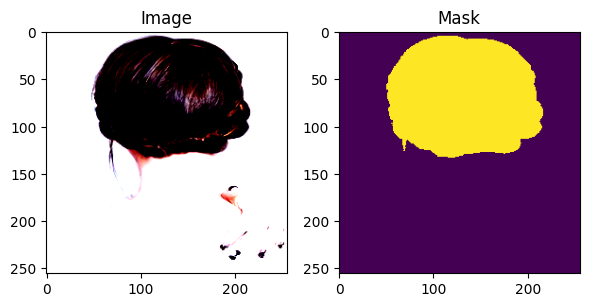

In [49]:
# Visual check
sample = train_dataset[0]
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].permute(1, 2, 0).numpy())
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].numpy())
plt.title("Mask")
plt.tight_layout()
plt.show()

In [50]:
# Model initialization
model = HairSegmentationMultitaskModel(
    encoder_name=config['HParams']['backbone'],
    num_global_classes=config['HParams']['nr_classification_classes'],
    num_seg_classes=config['HParams']['nr_segmentation_classes'],
    learning_rate=config['HParams']['l_r'],
    loss_function=config['HParams']['segmentation_loss']
)

In [56]:
# Trainer
trainer = pl.Trainer(
    accelerator=config['HParams']['device'],
    max_epochs=50,
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [57]:
# Training
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

# Validation + Testing
print("Validation Results:")
pprint(trainer.validate(model, dataloaders=valid_dataloader, verbose=False))

print("Test Results:")
pprint(trainer.test(model, dataloaders=test_dataloader, verbose=False))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params | Mode
-------------------------------------------------------------
0 | backbone        | FPN               | 5.8 M  | eval
1 | global_avg_pool | AdaptiveAvgPool2d | 0      | eval
2 | classifier      | Sequential        | 1.9 K  | eval
3 | seg_loss_fn     | CrossEntropyLoss  | 0      | eval
4 | class_loss_fn   | CrossEntropyLoss  | 0      | eval
-------------------------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.049    Total estimated model params size (MB)
0         Modules in train mode
318       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation Results:


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'val_acc': 0.738095223903656,
  'val_class_loss': 1.7685366868972778,
  'val_iou': 0.9497968554496765,
  'val_loss': 1.84829843044281,
  'val_seg_loss': 0.07976154237985611}]
Test Results:


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_acc': 0.738095223903656,
  'test_class_loss': 1.7685366868972778,
  'test_iou': 0.9497968554496765,
  'test_loss': 1.84829843044281,
  'test_seg_loss': 0.07976154237985611}]


In [58]:
# Predict & visualize results from test set
batch = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    logits_mask, logits_cls = model(batch["image"])
    pr_masks = torch.argmax(logits_mask, dim=1).float()
    pr_labels = torch.argmax(logits_cls, dim=1)

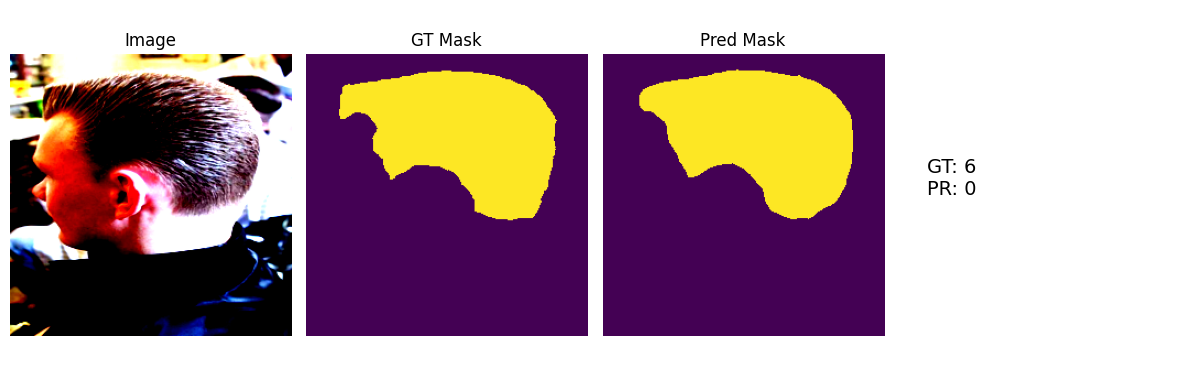

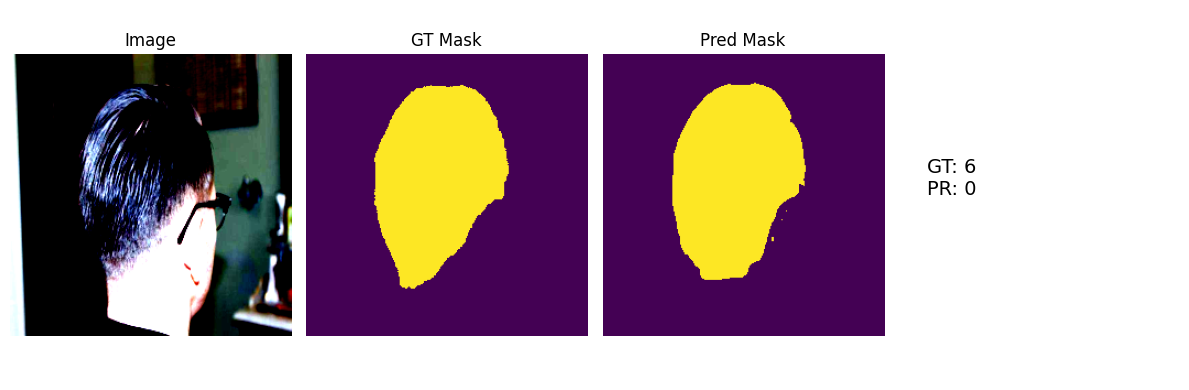

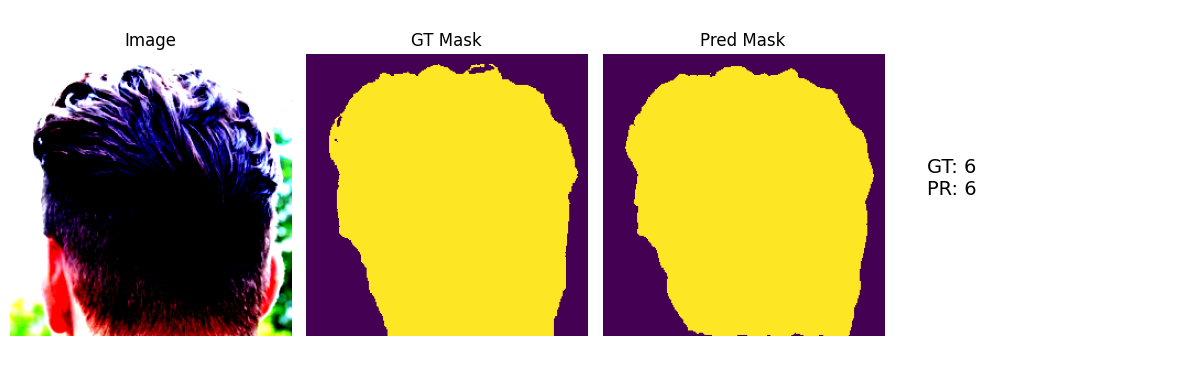

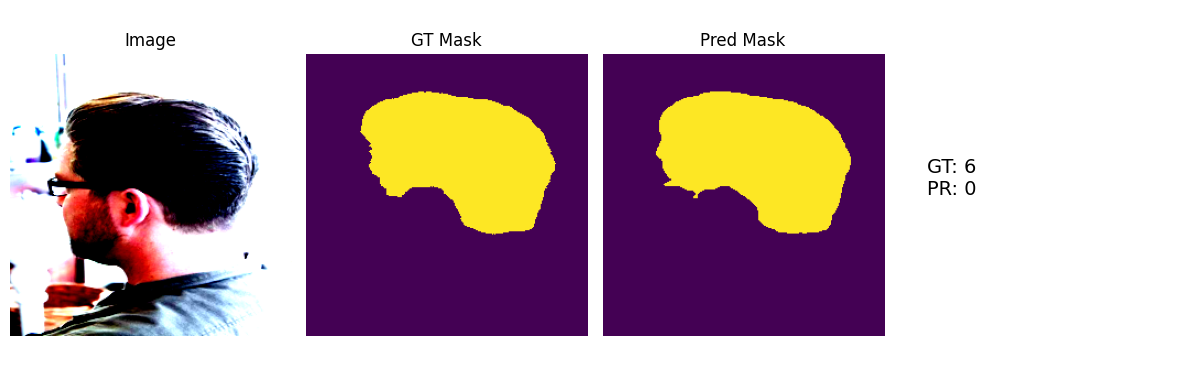

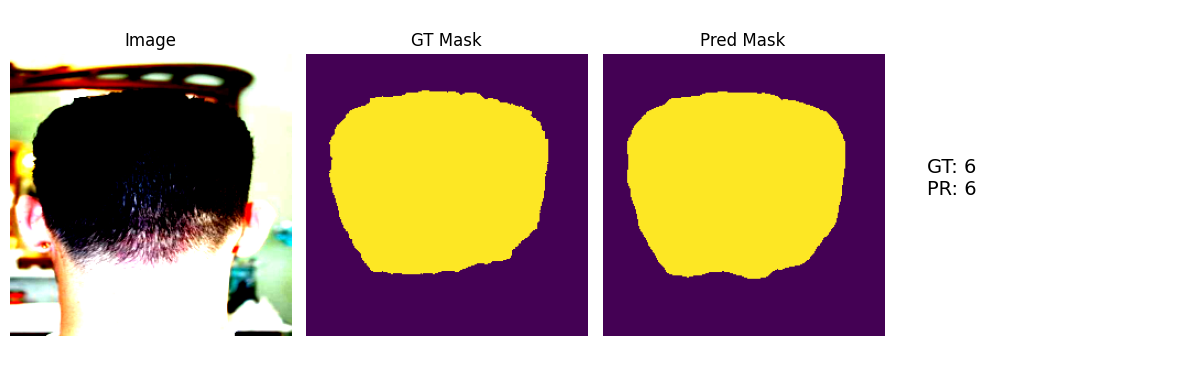

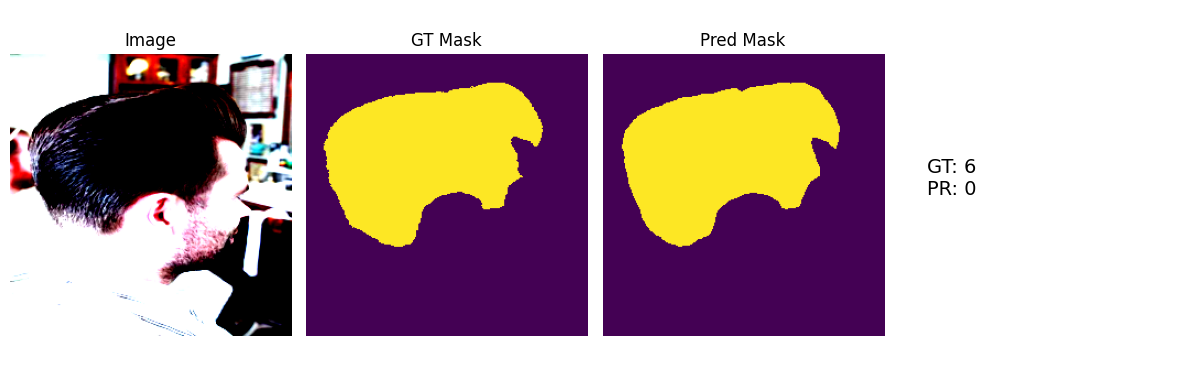

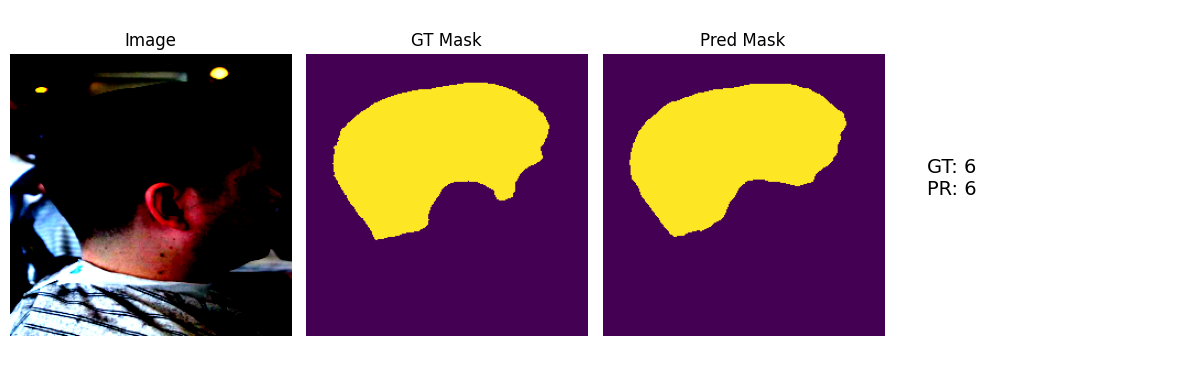

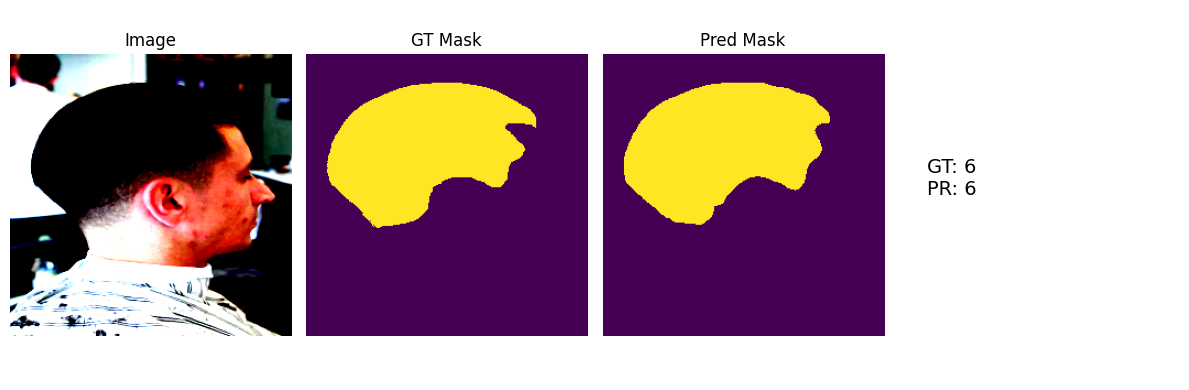

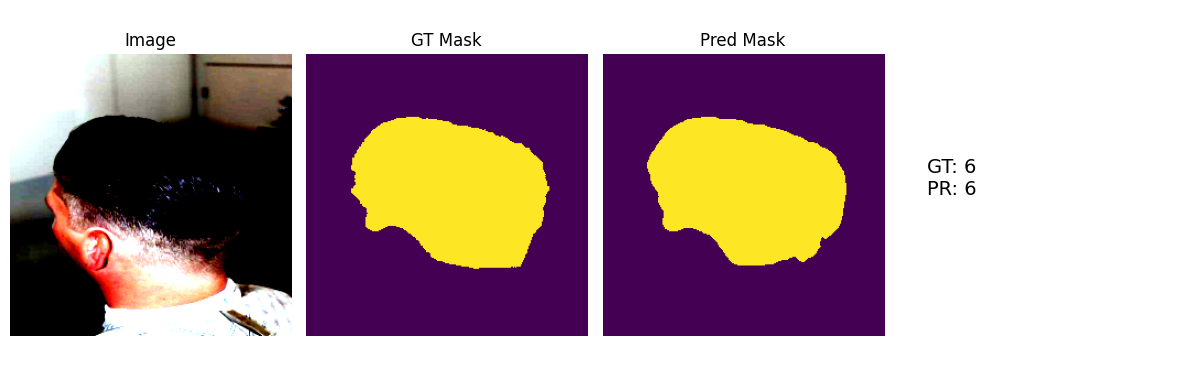

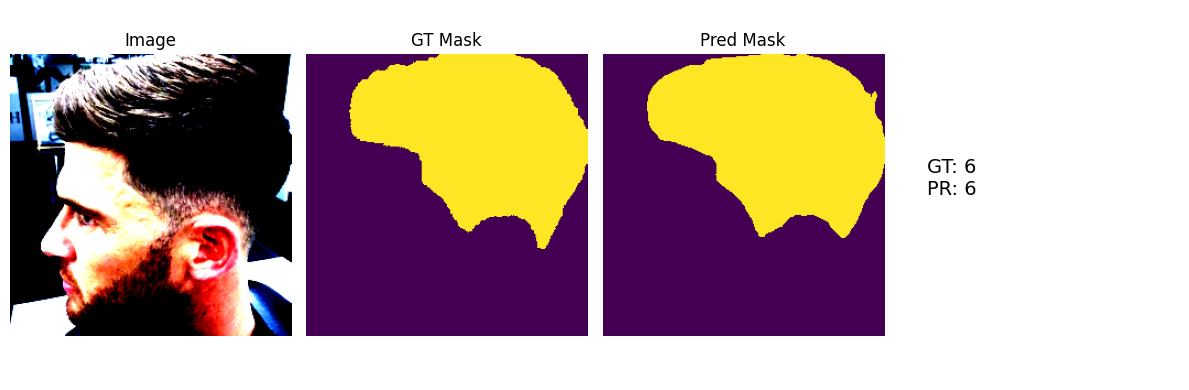

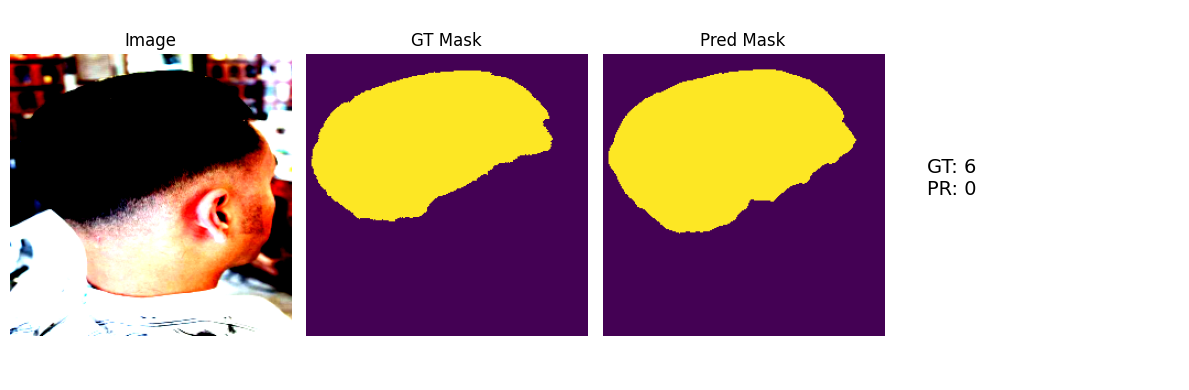

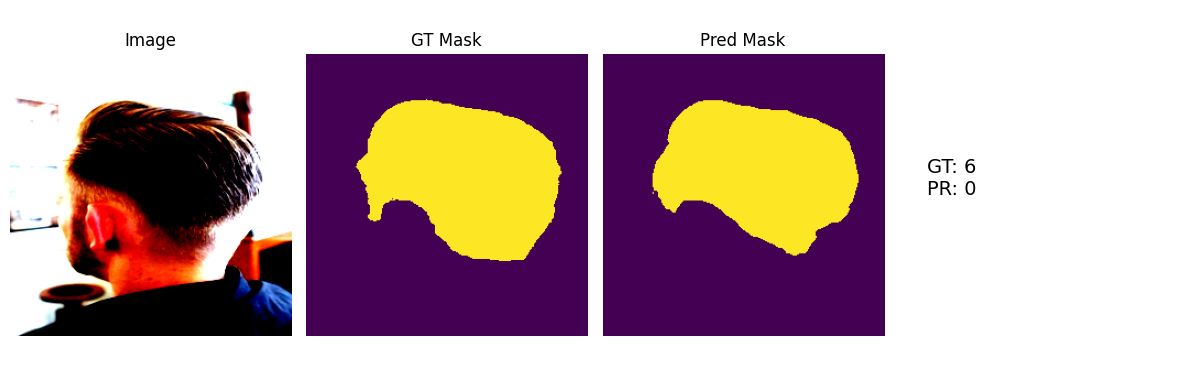

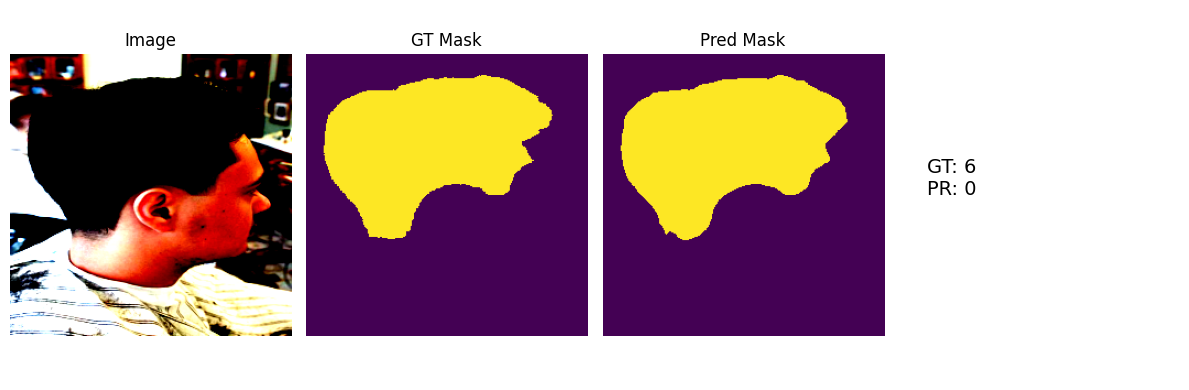

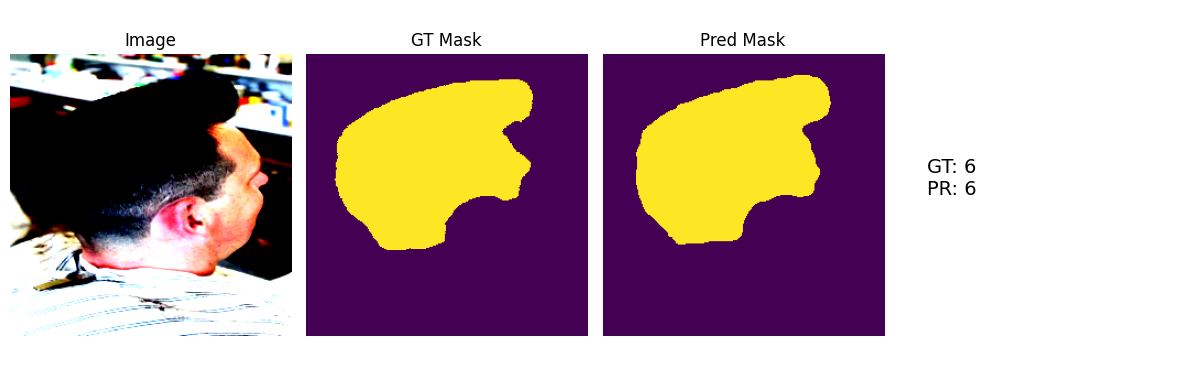

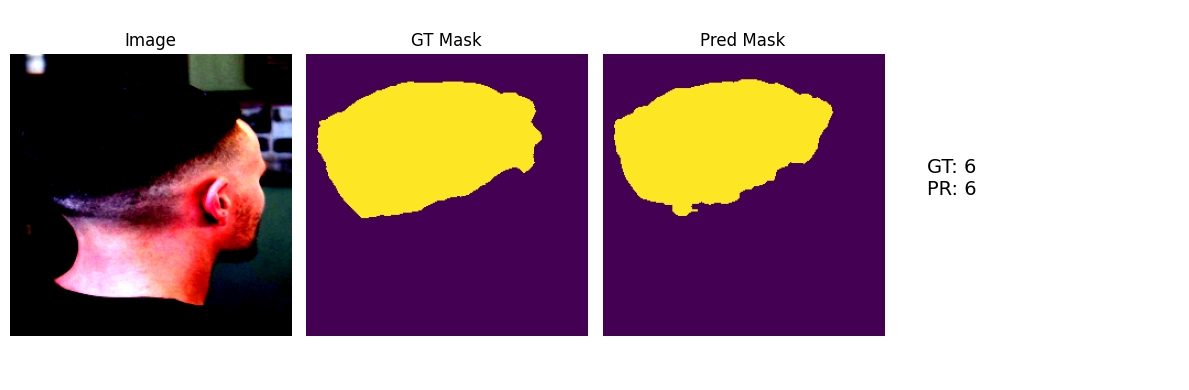

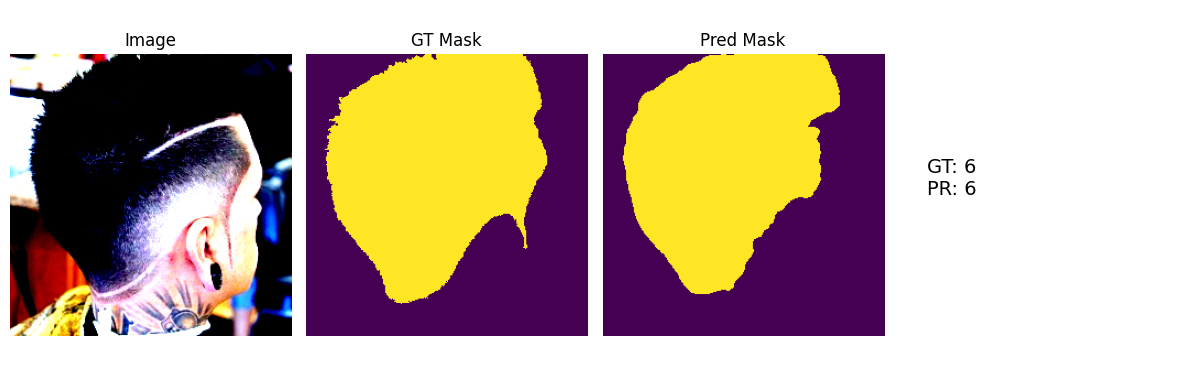

In [59]:
for image, gt_mask, gt_cls, pr_mask, pr_cls in zip(batch["image"], batch["mask"], batch["label"], pr_masks, pr_labels):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask.numpy())
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pr_mask.numpy())
    plt.title("Pred Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.text(0.1, 0.5, f"GT: {gt_cls.item()}\nPR: {pr_cls.item()}", fontsize=14)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [60]:
# Save model
save_path = os.path.join(config['SaveModel']['path'], "fpn_efficientnet_multiclass_256x256" + ".pth")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: ./models/fpn_efficientnet_multiclass_256x256.pth


# Test

In [63]:
def predict_from_path(image_path):
    # Transformations
    img_height, img_width = img_size if isinstance(img_size, (list, tuple)) else (img_size, img_size)

    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
    ])

    # Chargement de l'image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(model.device)  # Add batch dim

    # Prédiction
    model.eval()
    with torch.no_grad():
        seg_logits, class_logits = model(image_tensor)
        pr_mask = torch.argmax(seg_logits, dim=1)[0].cpu().numpy()
        pr_label = torch.argmax(class_logits, dim=1)[0].item()

    # Affichage
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pr_mask)
    plt.title(f"Pred Mask - Class: {pr_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


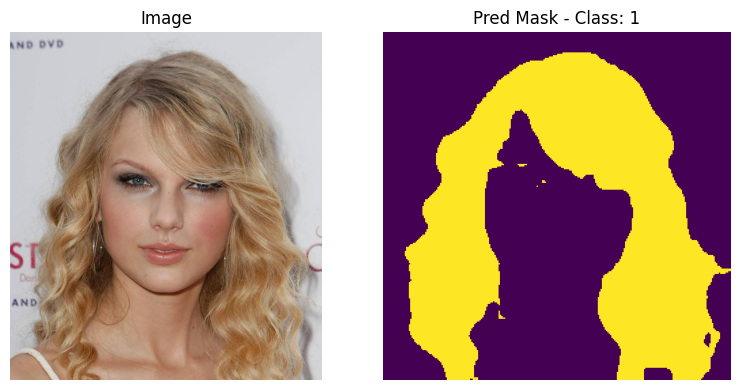

In [66]:
predict_from_path("/content/drive/MyDrive/Halisi/dataset/images/Frame00235_1_org.jpg")

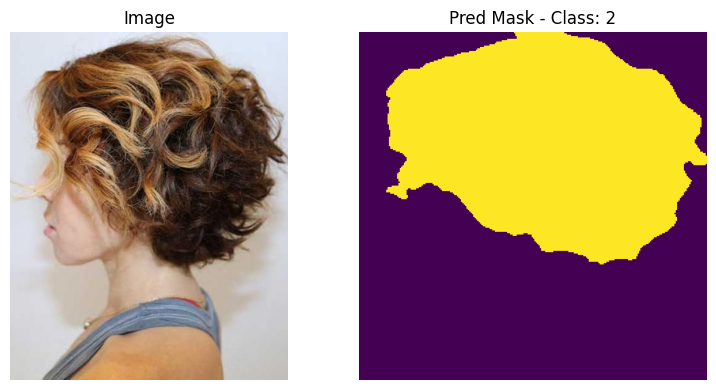

In [67]:
predict_from_path("/content/drive/MyDrive/Halisi/dataset/images/Frame00259_2_org.jpg")

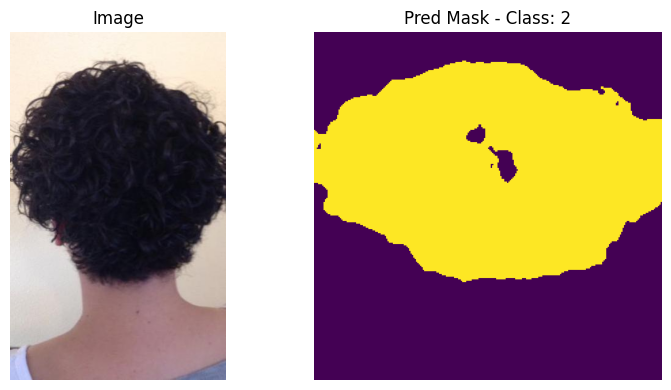

In [68]:
predict_from_path("/content/drive/MyDrive/Halisi/dataset/images/Frame00333_2_org.jpg")

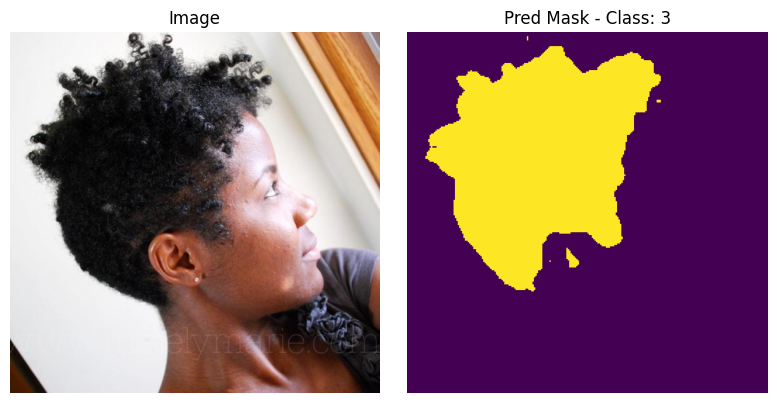

In [69]:
predict_from_path("/content/drive/MyDrive/Halisi/dataset/images/Frame00412_3_org.jpg")

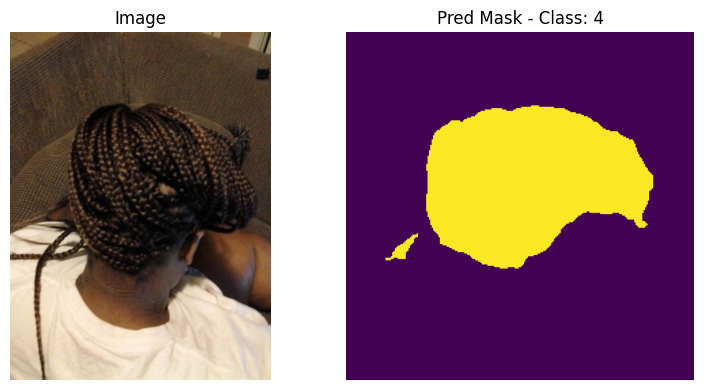

In [70]:
predict_from_path("/content/drive/MyDrive/Halisi/dataset/images/Frame00526_4_org.jpg")

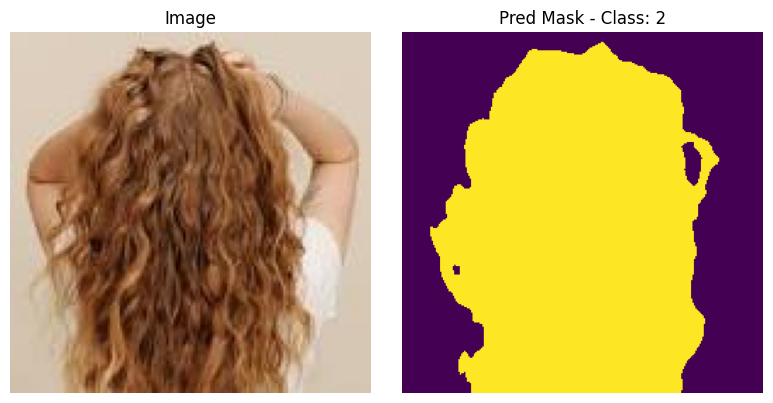

In [72]:
predict_from_path("/content/drive/MyDrive/Halisi/test/download (1).jpg")

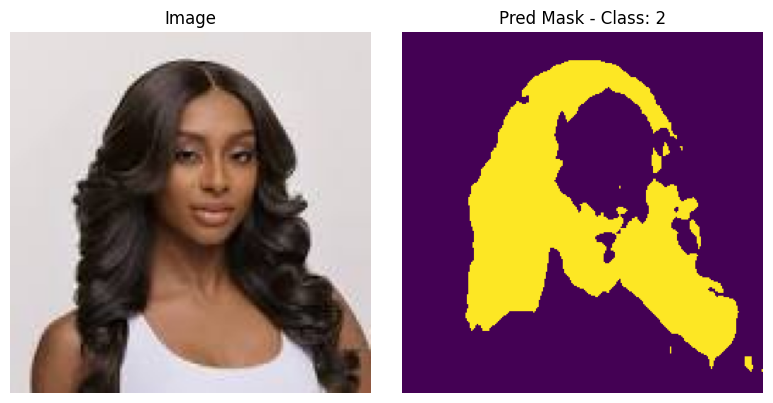

In [73]:
predict_from_path("/content/drive/MyDrive/Halisi/test/download.jpg")